In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from tqdm import tqdm
from scipy import stats
import import_ipynb
import GMMModelling as gmm

In [2]:
gdp = pd.read_csv("US_Nominal_GDP.csv")
debt = pd.read_csv("public_debt.csv")
gdp = gdp.rename(columns={'DATE': 'date', 'NGDPSAXDCUSQ': 'value'})

In [3]:
gdp

,date,value
0,1950-01-01,7.020700e+04
1,1950-04-01,7.259580e+04
2,1950-07-01,7.703830e+04
3,1950-10-01,7.998630e+04
4,1951-01-01,8.400000e+04
...,...,...
293,2023-04-01,6.765753e+06
294,2023-07-01,6.902532e+06
295,2023-10-01,6.989250e+06
296,2024-01-01,7.067294e+06


In [4]:
gdp = gdp.iloc[64:len(gdp)-5, :].reset_index().iloc[:, 1:]

In [5]:
X = np.array(gdp["value"])
Y = np.array(debt["value"])
X = X/1e6
Y = Y/1e6

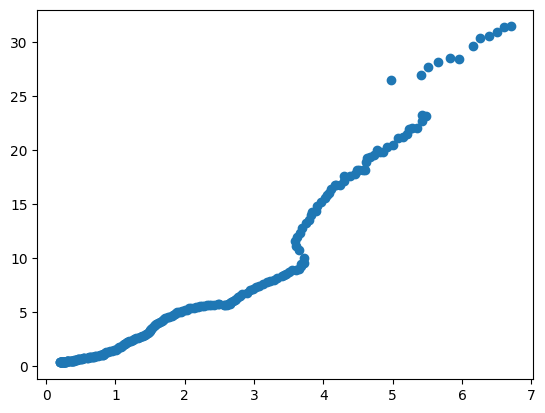

In [6]:
plt.scatter(X, Y)

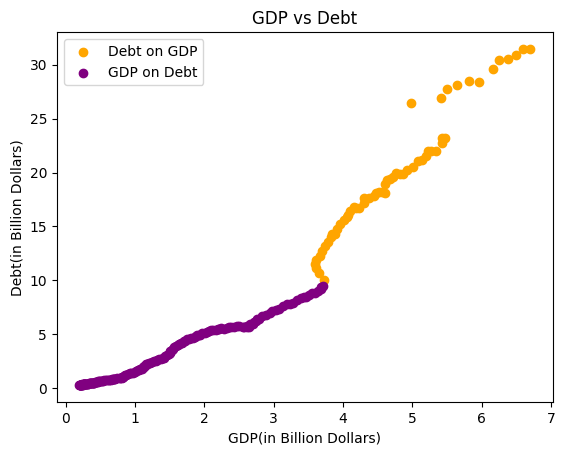

In [7]:
Z = gmm.Z   

X1 = X[Z == 1]
X2 = X[Z == 0]
Y1 = Y[Z == 1]
Y2 = Y[Z == 0]

plt.figure()
plt.scatter(X1, Y1, c = "orange", label = "Debt on GDP")
plt.scatter(X2, Y2, c = "purple", label = "GDP on Debt")
plt.legend()
plt.title("GDP vs Debt")
plt.xlabel("GDP(in Billion Dollars)")
plt.ylabel("Debt(in Billion Dollars)")
plt.show()

In [8]:
X1

array([3.72474975, 3.65205225, 3.6077255 , 3.595309  , 3.6122205 ,
       3.66281225, 3.6911525 , 3.74504825, 3.78540175, 3.8273685 ,
       3.837862  , 3.88938475, 3.91192   , 3.96056475, 4.01720125,
       4.05177875, 4.07988525, 4.10510475, 4.16204725, 4.18217175,
       4.2384595 , 4.298005  , 4.2994345 , 4.379627  , 4.451057  ,
       4.47802   , 4.5158825 , 4.569946  , 4.6004065 , 4.6087845 ,
       4.6314835 , 4.6779255 , 4.72316   , 4.772345  , 4.820021  ,
       4.859661  , 4.923149  , 5.009272  , 5.0821385 , 5.145228  ,
       5.1996825 , 5.229467  , 5.2760335 , 5.346194  , 5.4235705 ,
       5.4755975 , 5.4266285 , 4.978286  , 5.41191   , 5.5061255 ,
       5.6500465 , 5.8230905 , 5.9572435 , 6.163651  , 6.257279  ,
       6.3860685 , 6.49866   , 6.6021015 , 6.7034005 ])

## Getting the coefficients for a Simple Quadratic Regression

In [9]:
[a, b, c] = np.polyfit(X, Y, 2)

In [10]:
a,b,c

(0.6460656714354706, 0.8578272692490471, 0.11587014579886798)

In [11]:
def grad_a(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x**2)
def grad_b(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2*x)
def grad_c(x, y, a, b, c):
    return (y - a*x**2 - b*x - c)*(-2)
def swap_grad_a(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(-b/a**2 + (b**2 + 4*a*y - 4*a*c)**0.5 / (2*a**2) - (y-c)/(a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_b(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(1/(2*a) - b/(2*a*(b**2 + 4*a*y - 4*a*c)**0.5))
def swap_grad_c(x, y, a, b, c):
    return 2*(x + b/(2*a) - (b**2 +4*a*y - 4*a*c)**0.5/(2*a))*(2/(b**2 + 4*a*y - 4*a*c)**0.5)

In [12]:
def grad_lin_m(x, y, m, c):
    return (y - m*x - c)*(-2*x)
def grad_lin_c(x, y, m, c):
    return (y - m*x - c)*(-2)
def swap_grad_lin_m(x, y, m, c):
    return (x - y/m + c/m) * 2 * (y/m**2 - c/m**2)
def swap_grad_lin_c(x, y, m, c):
    return (x - y/m + c/m) * 2 * (1/m)

In [13]:
def Swap(X, Y, Z, a0 = a, b0 = b, c0 = c, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    a = a0
    b = b0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gA += lr*grad_a(X[i], Y[i], a, b, c)
                gB += lr*grad_b(X[i], Y[i], a, b, c)
                gC += lr*grad_c(X[i], Y[i], a, b, c)
            if Z[i] == 0:
                try:
                    if b**2 + 4*a*Y[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X[i], Y[i], a, b, c)
                        gB += lr*swap_grad_b(X[i], Y[i], a, b, c)
                        gC += lr*swap_grad_c(X[i], Y[i], a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
        gA /= (len(X) - err)
        gB /= (len(X) - err)
        gC /= (len(X) - err)
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
        if err/len(Z) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gA**2 + gB**2 + gC**2)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [a, b, c]

In [14]:
def SwapLin(X, Y, Z, m0, c0, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2):
    m = m0
    c = c0
    L = []
    ep = []
    for e in tqdm(range(0, int(epochs))):
        gM = 0
        gC = 0
        err = 0
        for i in range(0, len(Z)):
            if Z[i] == 1:
                gM += lr*grad_lin_m(X[i], Y[i], m, c)
                gC += lr*grad_lin_c(X[i], Y[i], m, c)
            if Z[i] == 0:
                gM += lr*swap_grad_lin_m(X[i], Y[i], m, c)
                gC += lr*swap_grad_lin_c(X[i], Y[i], m, c)
        gM /= len(X)
        gC /= len(X)
        ep.append(e + 1)
        L.append(gM**2 + gC**2)
        if err/len(Z) < error:
            m -= gM * lr
            c -= gC * lr
        else:
            m -= gM * lr
            c -= gC * lr
        if gM**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gM**2 + gC**2)
            return [m, c]
        if e == int(epochs) - 1:
            print(gM**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [m, c]

In [15]:
def StochasticSwap(X, Y, Z, a0 = a, b0 = b, c0 = c, epochs = 1e5, lr = 1e-7, error = 0.25, ers = 1e-2, batch = 200):
    a = a0
    b = b0
    c = c0
    L = []
    ep = []
    Batch = batch
    for e in tqdm(range(0, int(epochs))):
        gA = 0
        gB = 0
        gC = 0
        err = 0
 #       print(e)
 #       print(a, b, c)
        I = random.sample(range(0, len(X)), Batch)
        X_new = X[I]
        Y_new = Y[I]
        Z_new = Z[I]
        for i in range(0, len(Z_new)):
            if Z[i] == 1:
                gA += lr*grad_a(X_new[i], Y_new[i], a, b, c)
                gB += lr*grad_b(X_new[i], Y_new[i], a, b, c)
                gC += lr*grad_c(X_new[i], Y_new[i], a, b, c)
  #              print(gA, gB, gC)
            if Z[i] == 0:
                try:
 #                   print("Yes.")
 #                   print(swap_grad_a(X_new[i], Y_new[i], a, b, c))
 #                   print(swap_grad_b(X_new[i], Y_new[i], a, b, c))
 #                   print(swap_grad_c(X_new[i], Y_new[i], a, b, c))
                    if b**2 + 4*a*Y_new[i] - 4*a*c < 0:
                        err += 1
                    else:
                        gA += lr*swap_grad_a(X_new[i], Y_new[i], a, b, c)
                        gB += lr*swap_grad_b(X_new[i], Y_new[i], a, b, c)
                        gC += lr*swap_grad_c(X_new[i], Y_new[i], a, b, c)
#                    print(gA, gB, gC)
                except:
                    err += 1
#                    print("Nope.")
#                    print(gA, gB, gC)
 #       print(gA, gB, gC)
        gA /= (Batch - err)
        gB /= (Batch - err)
        gC /= (Batch - err)
        ep.append(e + 1)
        L.append(gA**2 + gB**2 + gC**2)
 #       print(gA, gB, gC)
        if err/len(Z_new) < error:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        else:
            a -= gA * lr
            b -= gB * lr
            c -= gC * lr
        if gA**2 + gB**2 + gC**2 < ers:
            plt.plot(ep, L)
            print(gA**2 + gB**2 + gC**2)
            return [a, b, c]
        if e == int(epochs) - 1:
            print(gA**2 + gB**2 + gC**2)
    print("Meh.")
    plt.plot(ep, L)
    return [a, b, c]

In [16]:
m1, c1, r, p, std_err = stats.linregress(X1, Y1)
m2, c2, _, _, _ = stats.linregress(Y2, X2)
c4 = -c2/m2
m4 = 1/m2
m2, c2, _, _, _ = stats.linregress(X2, Y2)
m3, c3, _, _, _ = stats.linregress(X, Y)

100%|████████████████████████████████████| 40000/40000 [01:01<00:00, 645.18it/s]


1.580075010372739e-07
Meh.


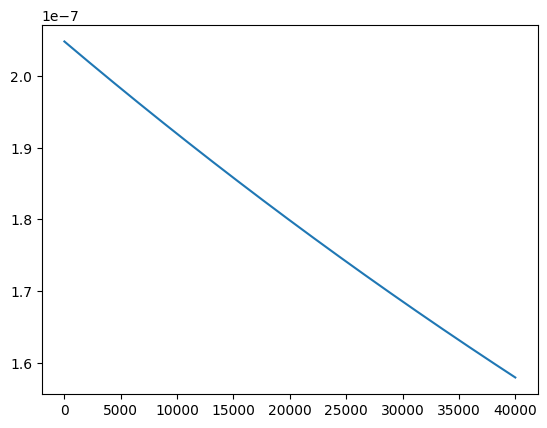

In [17]:
S = Swap(X, Y, Z, epochs = 4e4, lr = 1e-4, ers = 1e-30)

100%|███████████████████████████████████| 70000/70000 [00:29<00:00, 2343.61it/s]


1.4575296936767612e-11
Meh.


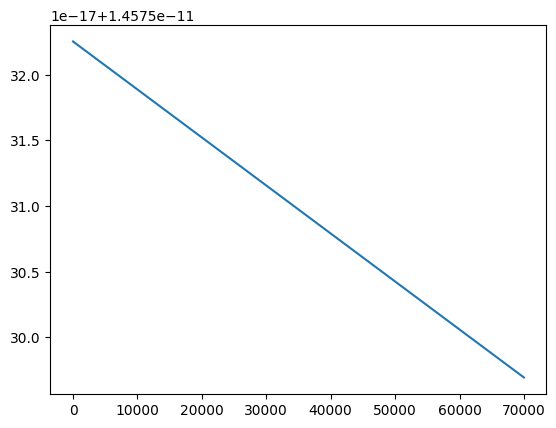

In [18]:
L = SwapLin(X, Y, Z, m0 = m3, c0 = c3, epochs = 7e4, lr = 1e-6, ers = 1e-30)

In [19]:
len(X)

229

In [20]:
a, b, c

(0.6460656714354706, 0.8578272692490471, 0.11587014579886798)

In [21]:
S

[0.6477009742520201, 0.8582714281037206, 0.11597205627120324]

In [22]:
def makeLineSwap(x, y, z, m1, c1, m2, c2):
    Y = []
    for i in range(0, len(z)):
        if z[i] == 1:
            Y.append(m1*x[i] + c1)
        else:
            Y.append(m2*x[i] + c2)
    return x, Y

In [23]:
def makeLine(x, y, m, c):
    x0 = min(x)
    x1 = max(x)
    return [x0, x1], [m*x0 + c, m*x1 + c]

In [24]:
def QuadPred(x, a, b, c):
    return np.array([a*x[i]**2 + b*x[i] + c for i in range(len(x))])

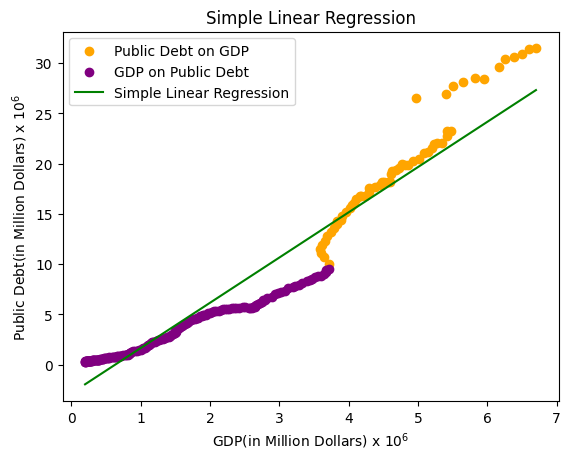

In [25]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")

A, B = makeLine(X, Y, m3, c3)
plt.plot(A, B, label = "Simple Linear Regression", c = "green")
plt.title("Simple Linear Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [26]:
m3, c3

(4.4972477180497235, -2.840483200739338)

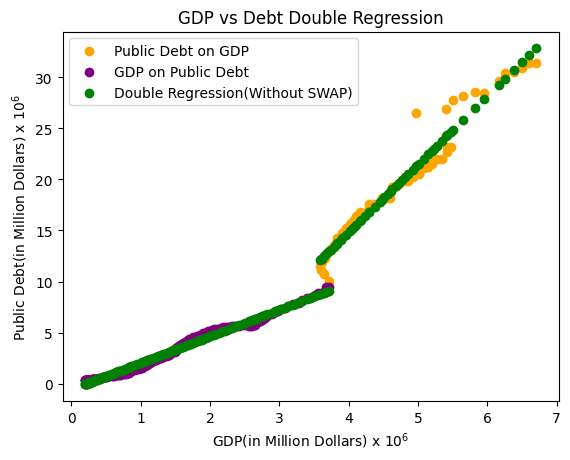

In [27]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")

A, B = makeLineSwap(X, Y, Z, m1, c1, m2, c2)
plt.scatter(A, B, label = "Double Regression(Without SWAP)", c = "green")
plt.title("GDP vs Debt Double Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [28]:
m1, c1, m2, c2

(6.672494347157568,
 -11.880838091108089,
 2.6106553833085044,
 -0.5892641045888785)

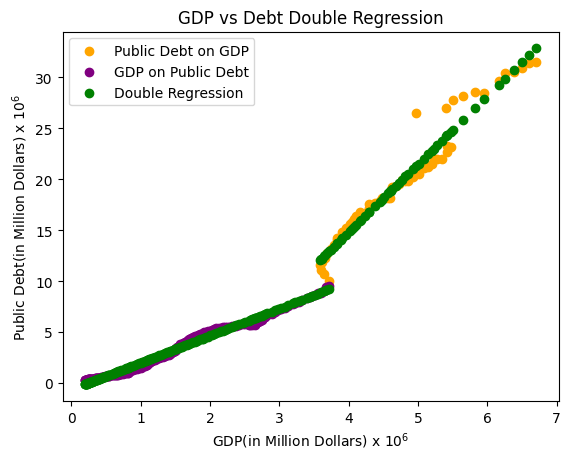

In [29]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")

A, B = makeLineSwap(X, Y, Z, m1, c1, m4, c4)
plt.scatter(A, B, label = "Double Regression", c = "green")
plt.title("GDP vs Debt Double Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

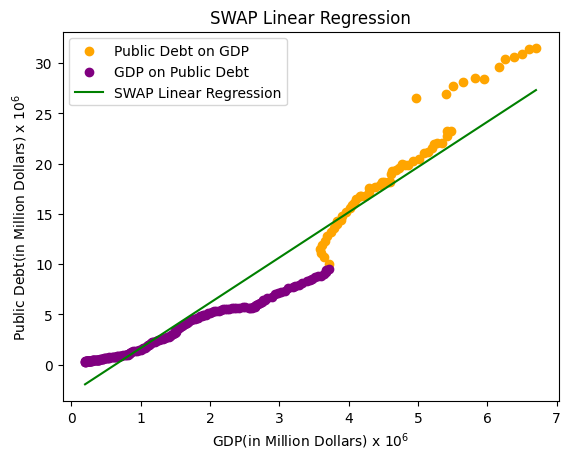

In [30]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")

A, B = makeLine(X, Y, L[0], L[1])
plt.plot(A, B, label = "SWAP Linear Regression", c = "green")
plt.title("SWAP Linear Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [31]:
m1, c1, m4, c4

(6.672494347157568, -11.880838091108089, 2.64948072573831, -0.6446244152698146)

In [32]:
L

[4.497247981723251, -2.8404831573740266]

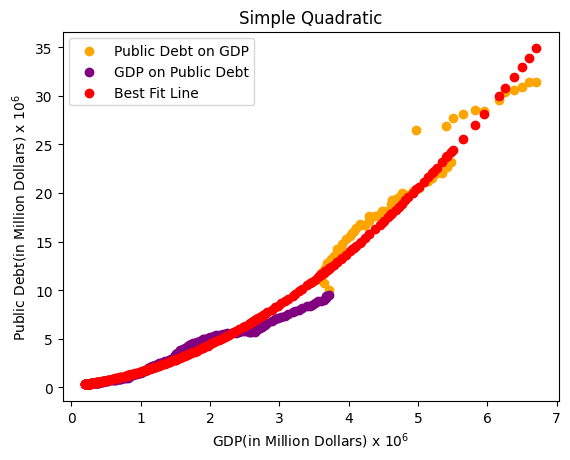

In [33]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")

plt.scatter(X,QuadPred(X,a,b,c),c = "red", label = 'Best Fit Line')
plt.title("Simple Quadratic")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [34]:
a, b, c

(0.6460656714354706, 0.8578272692490471, 0.11587014579886798)

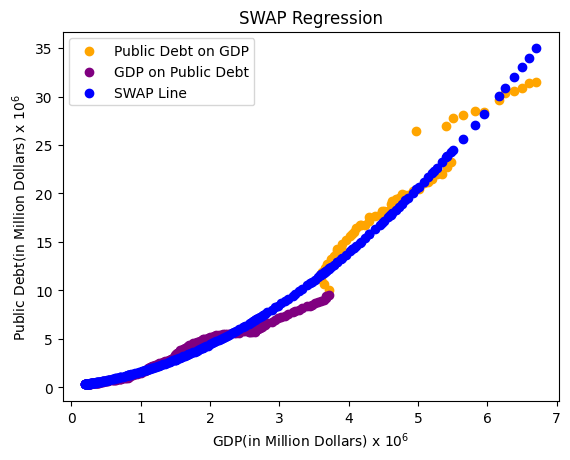

In [35]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")
plt.scatter(X,QuadPred(X,S[0],S[1],S[2]),c = "blue", label = 'SWAP Line')
plt.title("SWAP Regression")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [36]:
S

[0.6477009742520201, 0.8582714281037206, 0.11597205627120324]

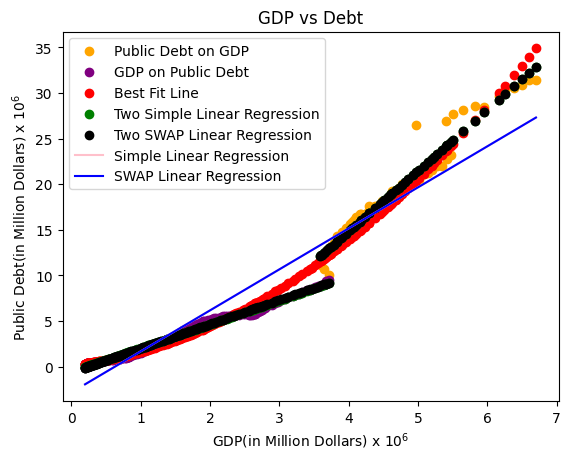

In [37]:
"""
plt.scatter(
    X,
    Y,
    c = Z,
    label = 'Observations'
)"""
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange")
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple")

plt.scatter(X,QuadPred(X,a,b,c),c = "red", label = 'Best Fit Line')
#plt.scatter(X,QuadPred(X,S[0],S[1],S[2]),c = "blue", label = 'Swap Line')
A, B = makeLineSwap(X, Y, Z, m1, c1, m2, c2)
plt.scatter(A, B, label = "Two Simple Linear Regression", c = "green")
A, B = makeLineSwap(X, Y, Z, m1, c1, m4, c4)
plt.scatter(A, B, label = "Two SWAP Linear Regression", c = "black")
A, B = makeLine(X, Y, m3, c3)
plt.plot(A, B, label = "Simple Linear Regression", c = "pink")
A, B = makeLine(X, Y, L[0], L[1])
plt.plot(A, B, label = "SWAP Linear Regression", c = "blue")
plt.title("GDP vs Debt")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

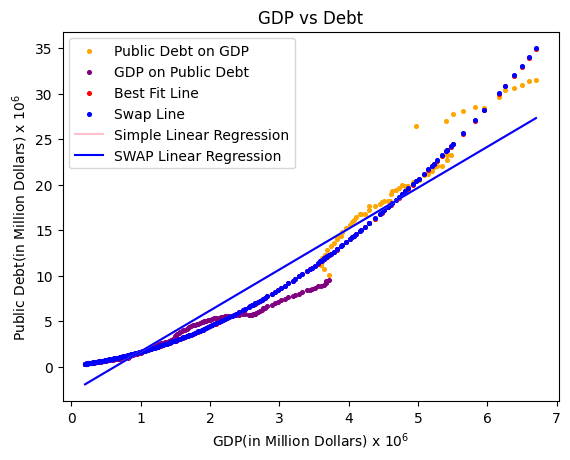

In [38]:
plt.scatter(X1, Y1, label = "Public Debt on GDP", c = "orange", s = 7)
plt.scatter(X2, Y2, label = "GDP on Public Debt", c = "purple", s = 7)

plt.scatter(X,QuadPred(X,a,b,c),c = "red", label = 'Best Fit Line', s = 7)
plt.scatter(X,QuadPred(X,S[0],S[1],S[2]),c = "blue", label = 'Swap Line', s = 7)
A, B = makeLine(X, Y, m3, c3)
plt.plot(A, B, label = "Simple Linear Regression", c = "pink")
A, B = makeLine(X, Y, L[0], L[1])
plt.plot(A, B, label = "SWAP Linear Regression", c = "blue")
plt.title("GDP vs Debt")
plt.xlabel(r"GDP(in Million Dollars) x $10^{6}$")
plt.ylabel(r"Public Debt(in Million Dollars) x $10^{6}$")
plt.legend()
plt.show()

In [39]:
Y_lin = m3*X + c3
Y_lin_swap = L[0]*X + L[1]
Y_simple = a*X**2 + b*X + c
Y_swap = S[0]*X**2 + S[1]*X + S[2]
X_swap = -S[1]/(2*S[0]) + np.sqrt(S[1]**2 - 4*S[0]*(S[2] - Y))/(2*S[0])
X_simple = -b/(2*a) + np.sqrt(b**2 - 4*a*(c - Y))/(2*a)

In [40]:
def error(X, Y, Z, a, b, c):
    e = 0
    err = 0
    for i in (range(0, len(Z))):
        if Z[i] == 1:
            e += (Y[i] - a*X[i]**2 - b*X[i] - c)**2
        else:
            if (b**2 - 4*a*c + 4*a*Y[i]) >= 0:
                e += (X[i] + b/(2*a) - ((b**2 - 4*a*c + 4*a*Y[i])**0.5)/(2*a))**2
            else:
                err += 1
    return e/(len(X) - err - 3)

In [41]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - m1*X[i] - c1)**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - c2)/m2)**2
print("Error with 2 Simple Linear Regressions : " + str(e/(len(X) - 2)))

Error with 2 Simple Linear Regressions : 224.93761455725982


In [42]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - m1*X[i] - c1)**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - c4)/m4)**2
print("Error with 2 SWAP Linear Regressions : " + str(e/len(X)))

Error with 2 SWAP Linear Regressions : 222.9729226949555


In [43]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - m3*X[i] - c3)**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - c3)/m3)**2
print("Error with Simple Linear Regression : " + str(e/(len(X) - 2)))

Error with Simple Linear Regression : 119.6980363358755


In [44]:
e = 0
for i in range(0, len(X1)):
    e += (Y1[i] - L[0]*X[i] - L[1])**2
for i in range(0, len(X2)):
    e += (X2[i] - (Y2[i] - L[1])/L[0])**2
print("Error with SWAP Linear Regression : " + str(e/(len(X) - 2)))

Error with SWAP Linear Regression : 119.69803468975229


In [45]:
print("Error with Simple Quadratic Regression : " + str(error(X, Y, Z, a, b, c)))

Error with Simple Quadratic Regression : 0.7060894662177016


In [46]:
print("Error with Swap Regression : " + str(error(X, Y, Z, S[0], S[1], S[2])))

Error with Swap Regression : 0.6988766165276609


In [47]:
print("Quad Err - Swap Err : " + str(error(X, Y, Z, a, b, c) - error(X, Y, Z, S[0], S[1], S[2])))

Quad Err - Swap Err : 0.007212849690040768


In [48]:
et = Y[Z == 1] - Y_swap[Z == 1]
et_swap = X[Z == 0] - X_swap[Z == 0]

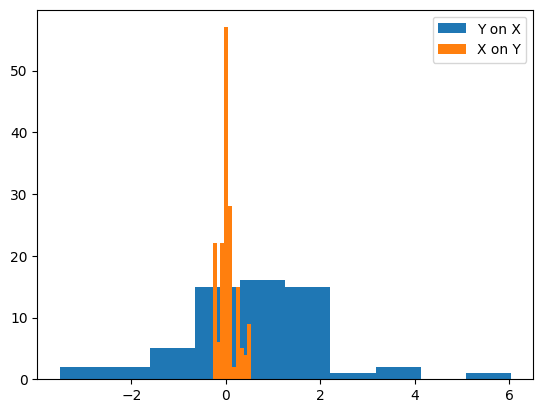

In [49]:
plt.hist(et, label = "Y on X")
plt.hist(et_swap, label = "X on Y")
plt.legend()
plt.show()

In [50]:
print(np.mean(et))
print(np.mean(et_swap))
print(np.std(et))
print(np.std(et_swap))

0.5450186434984557
0.04024925257686967
1.5074437783668575
0.1890257219264569


In [51]:
stats.ttest_ind(a=et, b=et_swap)

TtestResult(statistic=4.251574543824645, pvalue=3.102058105498862e-05, df=227.0)